In [6130]:
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

from PIL import Image
import os

In [6131]:
class ImagesDataset(Dataset):
    
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.img_names = os.listdir(root_dir)
        self.data_transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ToTensor()])
        
    def __getitem__(self, index):
        img = Image.open(self.root_dir + '/' + self.img_names[index]).convert('L')
        item = self.data_transforms(img)
        img.close()
        min = item.min()
        max = item.max()
        if min != max:
            item = (item - min) / (max - min)
        return item.view(1, 64, 64)

    def __len__(self):
        return len(self.img_names)

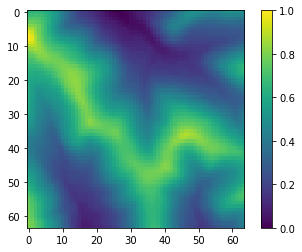

In [6132]:
import matplotlib.pyplot as plt

dataset = ImagesDataset('./data')
p = plt.imshow(dataset[6498].view(64, 64))
plt.colorbar(p)
plt.show()

In [6133]:
batch_size = 100
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [8024]:
def double_cnn(in_n, out_n):
    return nn.Sequential(
        nn.Conv2d(in_n, out_n, kernel_size=3, padding=1),
        nn.LeakyReLU(),
        nn.Conv2d(out_n, out_n, kernel_size=3, padding=1)
    )

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        # Encoder specification
        self.enc_cnn_1 = double_cnn(1, 32)
        self.enc_cnn_2 = double_cnn(32, 64)
        self.enc_cnn_3 = double_cnn(64, 96)
        self.enc_cnn_4 = double_cnn(96, 128)
        
        self.enc_linear_1_1 = nn.Linear(2048, 64)
        self.enc_linear_1_2 = nn.Linear(2048, 64)
        
        # Decoder specification
        self.dec_linear_1 = nn.Linear(64, 2048)
        
        self.dec_cnn_1 = double_cnn(128, 96)
        self.dec_cnn_2 = double_cnn(96, 64)
        self.dec_cnn_3 = double_cnn(64, 32)
        self.dec_cnn_4 = double_cnn(32, 1)
        
    def encode(self, data):
        x = self.enc_cnn_1(data)
        x = F.leaky_relu(F.max_pool2d(x, 2))

        x = self.enc_cnn_2(x)
        x = F.leaky_relu(F.max_pool2d(x, 2))

        x = self.enc_cnn_3(x)
        x = F.leaky_relu(F.max_pool2d(x, 2))

        x = self.enc_cnn_4(x)
        x = F.leaky_relu(F.max_pool2d(x, 2))

        x = x.view(x.size(0), -1)
        return self.enc_linear_1_1(x), self.enc_linear_1_2(x)
    
    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.cuda.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)
        
    def decode(self, z):
        out = F.leaky_relu(self.dec_linear_1(z))
        out = out.view(out.size(0), 128, 4, 4)
        
        out = F.interpolate(out, 8)
        out = F.leaky_relu(self.dec_cnn_1(out))
        
        out = F.interpolate(out, 16)
        out = F.leaky_relu(self.dec_cnn_2(out))
        
        out = F.interpolate(out, 32)
        out = F.leaky_relu(self.dec_cnn_3(out))
        
        out = F.interpolate(out, 64)
        out = F.leaky_relu(self.dec_cnn_4(out))
        
        return out
        
    def forward(self, data):
        mu, logvar = self.encode(data)
        z = self.reparametrize(mu, logvar)
        out = self.decode(z)
        return out, mu, logvar

In [8041]:
vae = VAE().cuda()

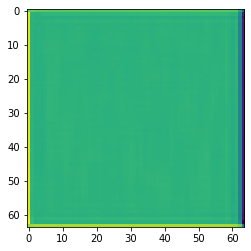

In [8042]:
x = dataset[400].cuda()
out, _, _ = vae(x.view(1, 1, 64, 64))
plt.imshow(out.view(64, 64).cpu().detach().numpy())
plt.show()

In [8043]:
import torch.optim as optim

def loss_function(recon_x, x, mu, logvar):
    MSE = nn.MSELoss(reduction='sum')(recon_x, x)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    KLD *= 0.1
    return MSE + KLD, MSE, KLD

optimizer = optim.Adam(vae.parameters(), lr=0.0001)

epochs = 100

for epoch in range(epochs):
    vae.train()
    i = 0
    for data in dataloader:
        i += 1
        optimizer.zero_grad()
        x = data.cuda()
        out, mu, logvar = vae(x)
        loss, MSE, KLD = loss_function(out, x, mu, logvar)
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            msg = "epoch[{}/{}], loss={:.3f}, MSE={:.3f}, KLD={:.3f}".format(epoch + 1, epochs, 
                  loss.item() / batch_size, MSE.item() / batch_size, KLD.item() / batch_size)
            print(msg)

epoch[1/100], loss=319.824, MSE=312.480, KLD=7.343
epoch[1/100], loss=157.049, MSE=148.070, KLD=8.979
epoch[1/100], loss=127.567, MSE=120.129, KLD=7.439
epoch[1/100], loss=114.378, MSE=107.421, KLD=6.956
epoch[1/100], loss=98.148, MSE=90.920, KLD=7.228
epoch[2/100], loss=100.449, MSE=92.640, KLD=7.809
epoch[2/100], loss=74.186, MSE=65.844, KLD=8.342
epoch[2/100], loss=68.196, MSE=60.430, KLD=7.765
epoch[2/100], loss=66.290, MSE=58.183, KLD=8.107
epoch[2/100], loss=69.336, MSE=60.814, KLD=8.522
epoch[3/100], loss=58.470, MSE=50.408, KLD=8.062
epoch[3/100], loss=62.872, MSE=54.479, KLD=8.393
epoch[3/100], loss=64.722, MSE=56.206, KLD=8.516
epoch[3/100], loss=60.608, MSE=52.270, KLD=8.338
epoch[3/100], loss=55.670, MSE=47.309, KLD=8.361
epoch[4/100], loss=59.295, MSE=51.171, KLD=8.124
epoch[4/100], loss=57.173, MSE=49.009, KLD=8.163
epoch[4/100], loss=58.112, MSE=50.217, KLD=7.895
epoch[4/100], loss=52.215, MSE=44.520, KLD=7.696
epoch[4/100], loss=60.998, MSE=53.023, KLD=7.975
epoch[5/100

epoch[34/100], loss=18.134, MSE=12.130, KLD=6.004
epoch[34/100], loss=20.504, MSE=14.217, KLD=6.286
epoch[34/100], loss=18.235, MSE=12.167, KLD=6.068
epoch[34/100], loss=20.915, MSE=14.547, KLD=6.368
epoch[34/100], loss=20.300, MSE=14.019, KLD=6.281
epoch[35/100], loss=19.625, MSE=13.347, KLD=6.277
epoch[35/100], loss=19.033, MSE=12.960, KLD=6.073
epoch[35/100], loss=18.843, MSE=12.664, KLD=6.179
epoch[35/100], loss=19.571, MSE=13.270, KLD=6.302
epoch[35/100], loss=19.531, MSE=13.371, KLD=6.159
epoch[36/100], loss=19.255, MSE=13.081, KLD=6.174
epoch[36/100], loss=20.057, MSE=13.714, KLD=6.343
epoch[36/100], loss=20.065, MSE=13.812, KLD=6.253
epoch[36/100], loss=19.048, MSE=12.830, KLD=6.218
epoch[36/100], loss=17.655, MSE=11.549, KLD=6.106
epoch[37/100], loss=21.014, MSE=14.904, KLD=6.110
epoch[37/100], loss=18.378, MSE=12.275, KLD=6.102
epoch[37/100], loss=20.141, MSE=14.047, KLD=6.093
epoch[37/100], loss=21.240, MSE=14.817, KLD=6.423
epoch[37/100], loss=19.236, MSE=13.016, KLD=6.219


epoch[66/100], loss=18.067, MSE=11.525, KLD=6.543
epoch[67/100], loss=17.416, MSE=11.000, KLD=6.415
epoch[67/100], loss=18.446, MSE=12.058, KLD=6.388
epoch[67/100], loss=18.269, MSE=11.799, KLD=6.470
epoch[67/100], loss=17.875, MSE=11.379, KLD=6.495
epoch[67/100], loss=18.597, MSE=11.990, KLD=6.607
epoch[68/100], loss=18.441, MSE=11.908, KLD=6.533
epoch[68/100], loss=17.408, MSE=10.906, KLD=6.501
epoch[68/100], loss=16.433, MSE=9.939, KLD=6.494
epoch[68/100], loss=18.921, MSE=12.102, KLD=6.819
epoch[68/100], loss=19.125, MSE=12.410, KLD=6.716
epoch[69/100], loss=18.083, MSE=11.369, KLD=6.714
epoch[69/100], loss=17.697, MSE=11.067, KLD=6.630
epoch[69/100], loss=17.789, MSE=11.146, KLD=6.642
epoch[69/100], loss=17.207, MSE=10.775, KLD=6.432
epoch[69/100], loss=17.189, MSE=10.781, KLD=6.408
epoch[70/100], loss=17.519, MSE=10.865, KLD=6.654
epoch[70/100], loss=17.525, MSE=10.883, KLD=6.642
epoch[70/100], loss=19.245, MSE=12.691, KLD=6.554
epoch[70/100], loss=17.344, MSE=10.768, KLD=6.576
e

epoch[99/100], loss=17.009, MSE=10.140, KLD=6.869
epoch[100/100], loss=15.694, MSE=9.059, KLD=6.635
epoch[100/100], loss=15.408, MSE=8.821, KLD=6.587
epoch[100/100], loss=16.481, MSE=9.974, KLD=6.507
epoch[100/100], loss=17.884, MSE=11.173, KLD=6.711
epoch[100/100], loss=15.683, MSE=9.194, KLD=6.490


In [8044]:
torch.cuda.empty_cache()

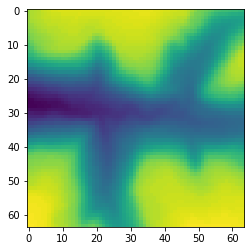

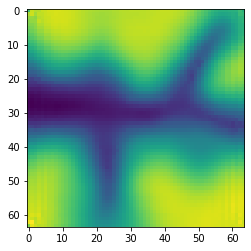

In [8048]:
x = dataset[5948].cuda()
plt.imshow(x.view(64, 64).cpu())
plt.show()
out, _, _ = vae(x.view(1, 1, 64, 64))
plt.imshow(out.view(64, 64).cpu().detach().numpy())
plt.show()

In [7992]:
#torch.save(vae.state_dict(), './vae_save')

In [7295]:
vae.load_state_dict(torch.load('./vae_save'))

<All keys matched successfully>

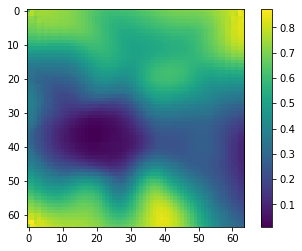

In [8488]:
# Generator
code = torch.FloatTensor(1, 64).normal_()

out = vae.decode(code.cuda())
p = plt.imshow(out.view(64, 64).cpu().detach().numpy())
plt.colorbar(p)
plt.show()